


# Question : 

    - 1. What make cases fail in access approve 
    - 2. How amazon evaluate if a request should be approved / disapproved
    - 3. Any obvious pattern about data ? 
    - 4. How many resources / managers type/Company role/ROLE_TITLE
    - 5. How many times resources / managers type show in dataset
         (how many accesses with types mentioned above)
    .. ?
    
# Process :
       - This dataset is a raw log like data, transform them to sth more clear 
         form (e.g. access profile) would help classification 
       - 1. select feature
       - 2. data clean 
       - 3. outlier remove 
       - 4. 
     

# Summary :




## ref :

- https://www.kaggle.com/c/amazon-employee-access-challenge/data
- https://www.kaggle.com/c/amazon-employee-access-challenge/discussion/5283#28620
- https://github.com/codelibra/Amazon-Employee-Access-Challenge/blob/master/Amazon-Employee-Access-Challenge.ipynb
- https://www.kaggle.com/c/amazon-employee-access-challenge/discussion/5283

## Column Descriptions


> - ACTION:	ACTION is 1 if the resource was approved, 0 if the resource was not
- RESOURCE:	An ID for each resource
- MGR_ID :	The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time
- ROLE_ROLLUP_1	:Company role grouping category id 1 (e.g. US Engineering)
- ROLE_ROLLUP_2	:Company role grouping category id 2 (e.g. US Retail)
- ROLE_DEPTNAME	:Company role department description (e.g. Retail)
- ROLE_TITLE:	Company role business title description (e.g. Senior Engineering Retail Manager)
- ROLE_FAMILY_DESC:	Company role family extended description (e.g. Retail Manager, Software Engineering)
- ROLE_FAMILY:	Company role family description (e.g. Retail Manager)
- ROLE_CODE : 	Company role code; this code is unique to each role (e.g. Manager)

In [135]:
# Load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [136]:
# load CSVs

df_train = pd.read_csv('~/Kaggle.com_mini_project/Amazon_access/train.csv')
df_test = pd.read_csv('~/Kaggle.com_mini_project/Amazon_access/test.csv')
sampleSubmission = pd.read_csv('~/Kaggle.com_mini_project/Amazon_access/sampleSubmission.csv')

In [137]:
#df_test.head()

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


Seems raw data are OK 

In [139]:
# check how many different positions/role/department in this system

for col in df_train.columns:
    print (str(col) + " -> " + str(len(df_train[col].unique())))

ACTION -> 2
RESOURCE -> 7518
MGR_ID -> 4243
ROLE_ROLLUP_1 -> 128
ROLE_ROLLUP_2 -> 177
ROLE_DEPTNAME -> 449
ROLE_TITLE -> 343
ROLE_FAMILY_DESC -> 2358
ROLE_FAMILY -> 67
ROLE_CODE -> 343


- ROLE_TITLE -> 343
- ROLE_CODE -> 343
- ROLE_TITLE and ROLE_CODE represent same thing  (i.e. ROLE_TITLE : role name, ROLE_CODE : role ID  )

In [140]:
# ROLE_TITLE and ROLE_CODE  r one-to-one relation 

df_train[df_train.ROLE_CODE==117888][['ROLE_CODE','ROLE_TITLE']].head()

,ROLE_CODE,ROLE_TITLE
15,117888,117885
73,117888,117885
81,117888,117885
151,117888,117885
201,117888,117885


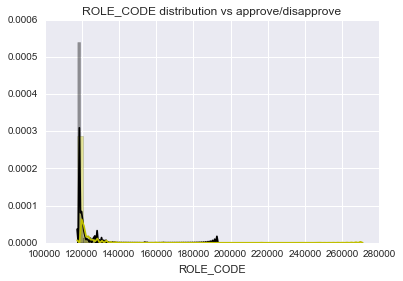

In [141]:
sns.distplot(df_train[df_train.ACTION == 0]['ROLE_CODE'],color="black")
sns.distplot(df_train[df_train.ACTION == 1]['ROLE_CODE'],color="y")

#df_train[df_train.ACTION == 0]['RESOURCE'].hist(bins=200, figsize=(11,8),color='black',stacked=False)
#df_train[df_train.ACTION == 1]['RESOURCE'].hist(bins=200, figsize=(11,8),color='r',stacked=False)

plt.title('ROLE_CODE distribution vs approve/disapprove')
plt.show()

- Some roles tend to apply much more accessed than others (maybe r engineer / analyst)
- More accesses, more approve and disapprove, value to check if some roles r more 
possible get approve than others 

In [142]:
# ACTION is 1 if the resource was approved, 0 if the resource was not

df_train.ACTION.value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

- 30872 of all 32769 accessess are appvoved, (only 5% access r disapproved)
- may need do some manipulation to balance approve / disapprove group in following steps
- It's an imbalance data 

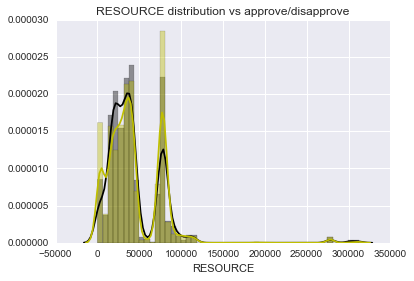

In [143]:
#df_train['RESOURCE'].hist(bins=100, figsize=(11,8),color='black')

sns.distplot(df_train[df_train.ACTION == 0]['RESOURCE'],color="black")
sns.distplot(df_train[df_train.ACTION == 1]['RESOURCE'],color="y")

#df_train[df_train.ACTION == 0]['RESOURCE'].hist(bins=200, figsize=(11,8),color='black',stacked=False)
#df_train[df_train.ACTION == 1]['RESOURCE'].hist(bins=200, figsize=(11,8),color='r',stacked=False)

plt.title('RESOURCE distribution vs approve/disapprove')
plt.show()

In [144]:
# check correlation

df_train.corr().iloc[:,:1].abs().sort('ACTION',ascending=False)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


,ACTION
ACTION,1.000000
ROLE_CODE,0.017147
ROLE_ROLLUP_1,0.013702
ROLE_TITLE,0.010169
ROLE_ROLLUP_2,0.005179
MGR_ID,0.005167
ROLE_FAMILY_DESC,0.003565
ROLE_DEPTNAME,0.001025
ROLE_FAMILY,0.000502
RESOURCE,0.000185


In [145]:
print ('TOP 3 correalation feature : ','[ROLE_CODE, ROLE_ROLLUP_1, ROLE_TITLE]')

TOP 3 correalation feature :  [ROLE_CODE, ROLE_ROLLUP_1, ROLE_TITLE]


In [146]:
df_train.head(4)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322


In [147]:
df_train[df_train.ACTION ==0].ROLE_ROLLUP_1.mean()

117553.7496046389

In [148]:
df_train[df_train.ACTION ==1].ROLE_ROLLUP_1.mean()

116915.69049624255

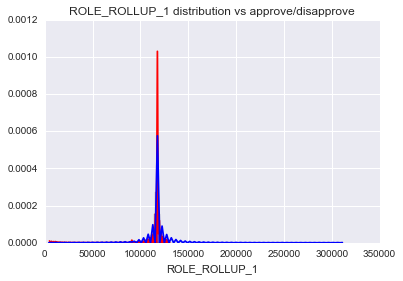

In [149]:
sns.distplot(df_train[df_train.ACTION == 0]['ROLE_ROLLUP_1'],color="r")
sns.distplot(df_train[df_train.ACTION == 1]['ROLE_ROLLUP_1'],color="b")

#df_train[df_train.ACTION == 0]['RESOURCE'].hist(bins=200, figsize=(11,8),color='black',stacked=False)
#df_train[df_train.ACTION == 1]['RESOURCE'].hist(bins=200, figsize=(11,8),color='r',stacked=False)

plt.title('ROLE_ROLLUP_1 distribution vs approve/disapprove')
plt.show()

In [150]:
#df_train[['ACTION','ROLE_ROLLUP_1']]

In [151]:
#df_train.columns[1:]

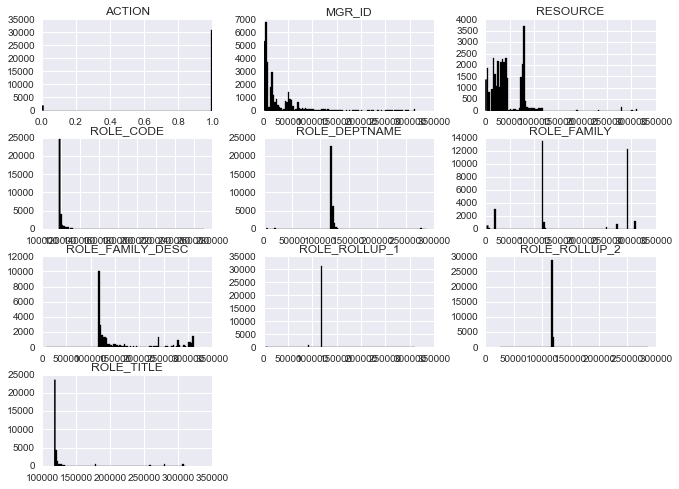

In [152]:
# get overview of data distribution 

df_train.hist(bins=100, figsize=(11,8),color='black')
plt.show()

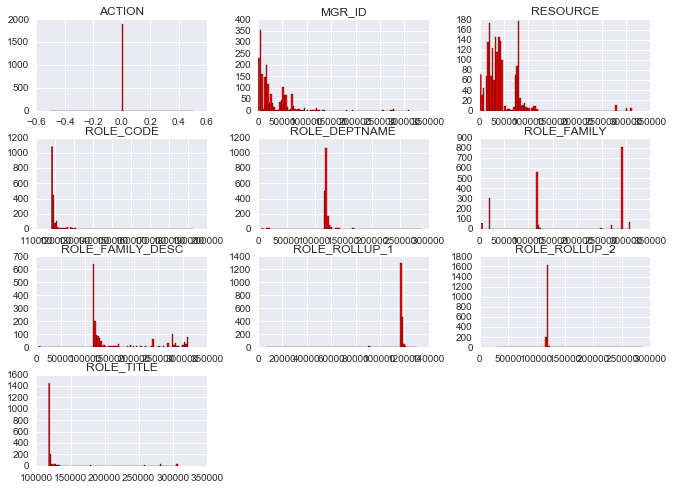

In [153]:
# find out what kind of access r disapproved (ACTION = 0 )

df_train[df_train.ACTION ==0].hist(bins=100, figsize=(11,8),color='red')
plt.show()

In [154]:
#sns.pairplot(df_train,hue="ACTION",dropna=True)

columns = RESOURCE


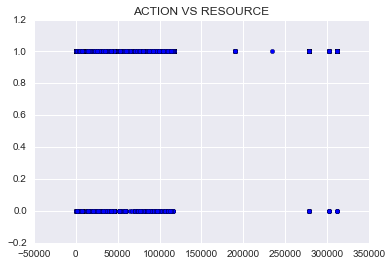

columns = MGR_ID


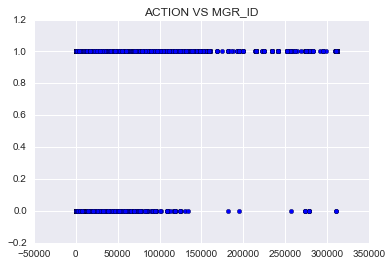

columns = ROLE_ROLLUP_1


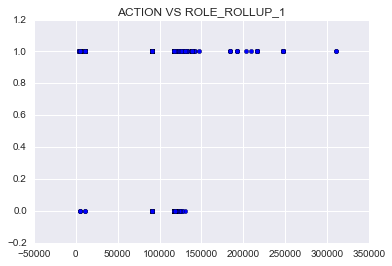

columns = ROLE_ROLLUP_2


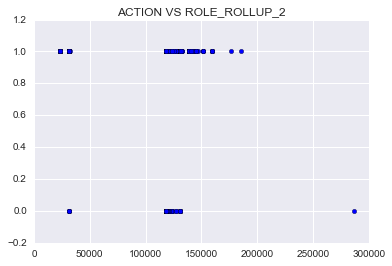

columns = ROLE_DEPTNAME


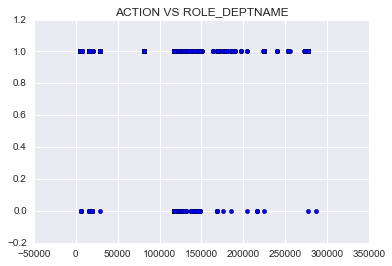

columns = ROLE_TITLE


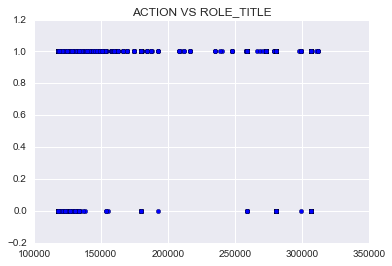

columns = ROLE_FAMILY_DESC


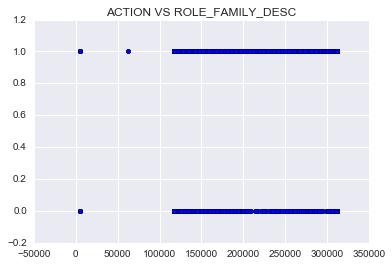

columns = ROLE_FAMILY


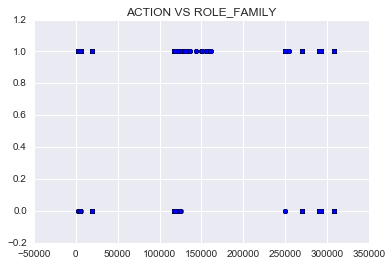

columns = ROLE_CODE


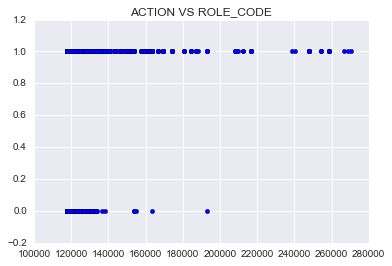

In [155]:
# check if there ACTION  ( 0 or 1 ) r sepeated well in some features 

columns = df_train.columns[1:]
for column in columns:
    print ('columns =', column)
    x = df_train[column]
    y = df_train['ACTION']
    plt.scatter(x, y)
    plt.title('ACTION VS {}'.format(column))
    plt.show()

    

## For all features :


- ROLE_ROLLUP_1, ROLE_ROLLUP_2, ROLE_FAMILY seems can be good seperated by simple logistics
  regression / SVM model (seems their data points r "dis-continuous" in some range)

In [156]:
# check if some RESOURCE r hard to "be access"

df_resource_act = df_train.groupby(['RESOURCE','ACTION']).count().reset_index()[['RESOURCE','ACTION','MGR_ID']]
df_resource_act.columns = ['RESOURCE','ACTION','count']

df_resource_act_ =  pd.pivot_table(df_resource_act,values ='count',\
                   index=['RESOURCE'],\
                   columns=['ACTION'],\
                   aggfunc=np.sum)\
                   .fillna(0).reset_index().set_index('RESOURCE')
df_resource_act_['pct_approve'] = df_resource_act_[1]/(df_resource_act_[0]+df_resource_act_[1])
#df_resource_act_['case_count'] = (df_resource_act_[0]+df_resource_act_[1])

#df_resource_act_.head(10)


## ***  How often resource / manager /... access show in dataset

In [157]:
#len(df_train([(df_train.RESOURCE ==0)&(df_train.ACTION ==1)]))
#len(df_train[(df_train.RESOURCE ==34924)&(df_train.ACTION ==1)])
#len((df_train[df_train.RESOURCE ==34924]))
#(df_train[df_train.RESOURCE ==0])

In [158]:
### new feature :   resource_cnt 


# https://stackoverflow.com/questions/37189878/pandas-add-column-to-groupby-dataframe
# groupby -> transform -> len:


df_train['resource_cnt'] = df_train.groupby('RESOURCE')['ACTION'].transform(len)
df_train['mgr_cnt'] = df_train.groupby('MGR_ID')['ACTION'].transform(len)
df_train['role_cnt'] = df_train.groupby('ROLE_CODE')['ACTION'].transform(len)

df_train['approve_access_cnt'] = df_train.groupby('RESOURCE')['ACTION'].transform(sum)
df_train['approve_mgr_cnt'] = df_train.groupby('MGR_ID')['ACTION'].transform(sum)
df_train['approve_role_cnt'] = df_train.groupby('ROLE_CODE')['ACTION'].transform(sum)

df_train['resource_approve_pct'] = df_train['approve_access_cnt']/df_train['resource_cnt']


In [159]:
#(df_train[df_train.RESOURCE ==0])

In [160]:
df_train.head(3)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,resource_cnt,mgr_cnt,role_cnt,approve_access_cnt,approve_mgr_cnt,approve_role_cnt,resource_approve_pct
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,3,55,3583,3,55,3467,1.000000
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,30,10,81,29,10,78,0.966667
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,2,3,1256,2,3,1117,1.000000


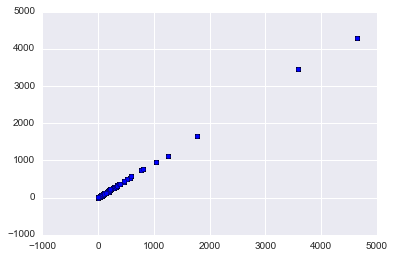

In [161]:
plt.scatter(df_train['role_cnt'],df_train['approve_role_cnt'])

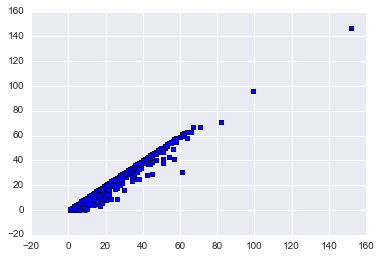

In [162]:
plt.scatter(df_train['mgr_cnt'],df_train['approve_mgr_cnt'])

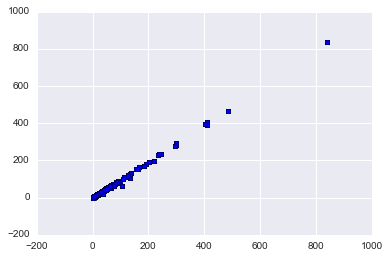

In [163]:
plt.scatter(df_train['resource_cnt'],df_train['approve_access_cnt'])

In [164]:
df_train.head(3)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,resource_cnt,mgr_cnt,role_cnt,approve_access_cnt,approve_mgr_cnt,approve_role_cnt,resource_approve_pct
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,3,55,3583,3,55,3467,1.000000
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,30,10,81,29,10,78,0.966667
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,2,3,1256,2,3,1117,1.000000


# Quick Summary :

